In [75]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [76]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

In [77]:
from colabgymrender.recorder import Recorder

In [78]:
# install dependencies
!apt install chromium-browser xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-browser is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.


In [79]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [80]:
total_reward

  and should_run_async(code)



-200.0

In [88]:
# # Hyperparameters
# max_epsilon = 1.0
# min_epsilon = 0.01
# max_num_steps = 50000
# epsilon_decay_intervals = 10000
# gamma = 0.99 # discount
# alpha = 5e-4 # learning rate

# memory_size = 50000
# min_replay_size = 1000
# batch_size = 32

# target_update_frequency = 1000 # target network update frequency

# Hyperparameters
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.001
max_num_steps = 150000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 8e-4 # learning rate

memory_size = 100000
min_replay_size = 1000
batch_size = 256

target_update_frequency = 1000 # target network update frequency

  and should_run_async(code)



In [82]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
            nn.Linear(128, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [83]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [84]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        if len(memory) >= batch_size:
            experiences = random.sample(memory, batch_size)
            states = torch.tensor([ex[0] for ex in experiences], dtype=torch.float32)
            actions = torch.tensor([ex[1] for ex in experiences], dtype=torch.int64).unsqueeze(-1)  # (batch_size,) --> (batch_size, 1)
            rewards = torch.tensor([ex[2] for ex in experiences], dtype=torch.float32).unsqueeze(-1)
            dones = torch.tensor([ex[3] for ex in experiences], dtype=torch.float32).unsqueeze(-1)
            next_states = torch.tensor([ex[4] for ex in experiences], dtype=torch.float32)

            # Compute targets using the formulation sample = r + gamma * max q(s',a')
            target_q_values = target_net(next_states)
            max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
            targets = rewards + gamma * (1 - dones) * max_target_q_values

            # Compute loss
            q_values = q_net(states)
            action_q_values = torch.gather(input=q_values, dim=1, index=actions)
            loss = torch.nn.functional.mse_loss(action_q_values, targets)

            # Gradient descent for q-network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network
            if (step + 1) % target_update_frequency == 0:
                target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [89]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -200.0
Episode: 40 Step: 8000 Average reward: -200.0
Episode: 45 Step: 9000 Average reward: -200.0
Episode: 50 Step: 10000 Average reward: -200.0
Episode: 55 Step: 11000 Average reward: -200.0
Episode: 60 Step: 12000 Average reward: -200.0
Episode: 65 Step: 13000 Average reward: -200.0
Episode: 70 Step: 14000 Average reward: -200.0
Episode: 75 Step: 15000 Average reward: -199.32
Episode: 80 Step: 16000 Average reward: -198.8625
Episode: 85 Step: 17000 Average reward: -198.9294117647059
Episode: 90 Step: 18000 Average reward: -197.87777777777777
Episode: 96 Step: 19000 Average reward: -197.08333333333334
Episode: 102 Step: 20000 Average reward: -195.15
Episode: 107 Step: 21000 A

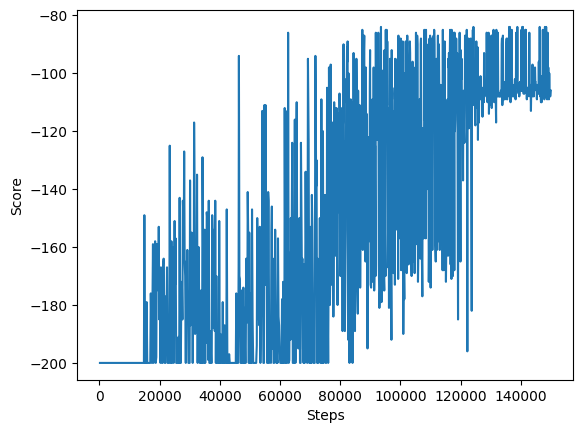

In [90]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [91]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-84.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
